In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import jax
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt
from jax import random
import pandas as pd
from scipy.optimize import minimize
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import Logit_JAX as lrj
import PriceSensitivity_Utils as ps

FS = (8, 4)  # figure size
RS = 124  # random seed

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
#n_feat = X.shape[1]
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.25, stratify=y, random_state=RS
#)
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_s = scaler.transform(X_train)
#X_test_s = scaler.transform(X_test)

In [3]:
# PPossible prices which can be offered to client
PRICE_LIST = jnp.arange(0,1,0.01)

# Price Sensitivity Parameters for 4 Client Groups
FEATURE_SPACE = jnp.asarray([jnp.asarray([0,1]), jnp.asarray([1,0])], dtype=jnp.float32)
PRICE_SENSITIVITY_PARMS = [[3,-0.1], [3,-0.3]]

ds = ps.simulate_dataset(
    N = 1000,
    features = FEATURE_SPACE,
    price_list = PRICE_LIST,
    price_sensitivity_parms = PRICE_SENSITIVITY_PARMS,
    seed = 12
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
ds.shape
X = ds[:3]
y = ds[3]
X = jnp.swapaxes(X,0,1)

In [5]:
n_feat = X.shape[1]
X_train_s, X_test_s, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RS
)

In [6]:
X_train_s.shape
y_train.shape

(750,)

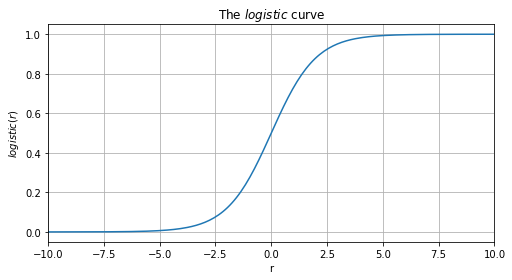

In [7]:
b = 10
r = jnp.linspace(-b, b, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, lrj.logistic(r))
ax.grid()
_ = ax.set(xlabel="r", ylabel="$logistic(r)$", title="The $logistic$ curve")
_ = ax.set_xlim(-b, b)

In [8]:
c_0 = 1.0
w_0 = 1.0e-5 * jnp.ones(n_feat)
print(lrj.cost(c_0, w_0, X_train_s, y_train))

1.0512689


# Batch Gradient Descent

In [9]:
%%time
n_iter = 1000
eta = 5e-2
tol = 1e-6
w = w_0
c = c_0
new_cost = float(lrj.cost(c, w, X_train_s, y_train))
cost_hist = [new_cost]
for i in range(n_iter):
    c_current = c
    c -= eta * grad(lrj.cost, argnums=0)(c_current, w, X_train_s, y_train)
    w -= eta * grad(lrj.cost, argnums=1)(c_current, w, X_train_s, y_train)
    new_cost = float(lrj.cost(c, w, X_train_s, y_train))
    cost_hist.append(new_cost)
    if (i > 20) and (i % 10 == 0):
        if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
            print(f"Exited loop at iteration {i}")
            break

Exited loop at iteration 840
CPU times: user 35.1 s, sys: 72 ms, total: 35.1 s
Wall time: 35.1 s


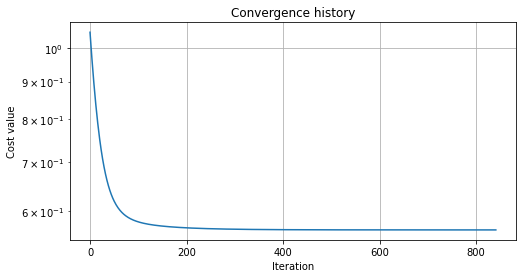

In [10]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(cost_hist)
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [11]:
y_pred_proba = lrj.predict_proba(c, w, X_test_s)
y_pred = jnp.array(y_pred_proba)
y_pred = jnp.where(y_pred < 0.5, y_pred, 1.0)
y_pred = jnp.where(y_pred >= 0.5, y_pred, 0.0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       172
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       250
   macro avg       0.34      0.50      0.41       250
weighted avg       0.47      0.69      0.56       250



# Stochastic Gradient Descent

In [12]:
%%time
n_iter = X_train_s.shape[0]#1000
eta = 5e-2
tol = 1e-6
w = w_0
c = c_0
new_cost = float(lrj.cost(c, w, X_train_s[0], y_train[0]))
cost_hist = [new_cost]
for i in range(n_iter):
    c_current = c
    c -= eta * grad(lrj.cost, argnums=0)(c_current, w, X_train_s[i], y_train[i])
    w -= eta * grad(lrj.cost, argnums=1)(c_current, w, X_train_s[i], y_train[i])
    new_cost = float(lrj.cost(c, w, X_train_s, y_train))
    cost_hist.append(new_cost)
    if (i > 20) and (i % 10 == 0):
        if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
            print(f"Exited loop at iteration {i}")
            break

CPU times: user 33.8 s, sys: 53.4 ms, total: 33.9 s
Wall time: 33.9 s


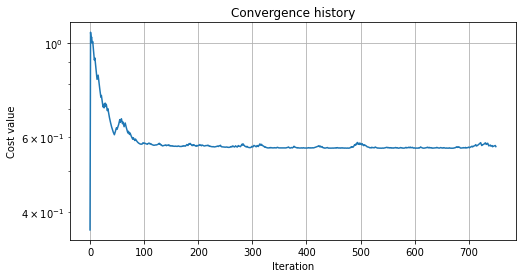

In [13]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(cost_hist)
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [14]:
y_pred_proba = lrj.predict_proba(c, w, X_test_s)
y_pred = jnp.array(y_pred_proba)
y_pred = jnp.where(y_pred < 0.5, y_pred, 1.0)
y_pred = jnp.where(y_pred >= 0.5, y_pred, 0.0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       172
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       250
   macro avg       0.34      0.50      0.41       250
weighted avg       0.47      0.69      0.56       250



In [15]:
c, w

(Array(-0.29071796, dtype=float32, weak_type=True),
 Array([-0.4283252 ,  0.11431004, -0.9654911 ], dtype=float32))

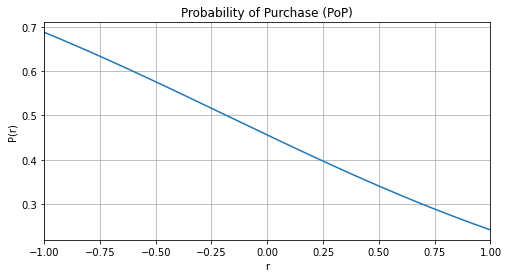

In [16]:
b = 1
r = jnp.linspace(-b, b, 200)
y = jnp.asarray([lrj.predict_proba(c, w, jnp.asarray([0,1,p])) for p in r])
_, ax = plt.subplots(figsize=FS)
plt.plot(r, y)
ax.grid()
_ = ax.set(xlabel="r", ylabel="P(r)", title="Probability of Purchase (PoP)")
_ = ax.set_xlim(-b, b)